In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def user_rc(lw=1.5, fontsize=16, usetex=True):
    """Set plotting RC parameters"""
    plt.rc('lines', linewidth=lw)
    plt.rc('axes', lw=lw, labelsize=fontsize, titlesize=22)
    if usetex:
        plt.rc('text', usetex=True)
        plt.rc('font', **{'family': 'serif'})#, 'serif': ['Computer Modern Roman', 'Times']})
    else:
        plt.rc('text', usetex=False)
        plt.rc('font', **{'family': 'serif'})#, 'serif': ['Ubuntu'], 'monospace': ['Ubuntu Mono']})#['Computer Modern']})
    plt.rc('xtick', labelsize=max(18, int(fontsize*0.8)))
    plt.rc('ytick', labelsize=max(18, int(fontsize*0.8)))
    plt.rc('figure', titlesize=22, figsize=(10,8))
    return
user_rc()

# Computing Transit Probability Following Li et al 2016: https://iopscience.iop.org/article/10.3847/0004-637X/831/1/96/pdf #

# Issues: #
- disagreement btw. avg number of transits (here seems to overestimate relative to paper figs at mutual inc ~ 90 deg)
    - resolved
- disagreement btw. P(transit at least once) as a function of binary inclination, for ap/ab=2.4 and Pb=2, 5 days.
    - resolved
- how to get from eq. 19 to eq. 20 in Li et al?
    - resolved

In [15]:
d2y = 365.2425 #days in a year
r2au = 0.0046491 #solar radii to AU
au = 1.49597e13 #AU in cm
TWOPI = 2*np.pi

def get_a(P, msum):
    """Compute semi-major axis given P (d) and sum of masses (Msun)"""
    return ((P/d2y)**2 * (msum))**(1/3.)

def get_P(a, msum):
    """Compute period given semi-major axis (AU) and sum of masses(Msun)"""
    return (a**3/msum)**(0.5) * d2y

def get_Pcrit(Pb, mA, mB, e):
    """Compute critical stability period given binary period, masses, and eccentricity"""
    a_b = ((Pb/d2y)**2 * (mA+mB))**(1./3.) #in AU
    mu = mB/(mA+mB)
    a_c = (1.6 + (5.1*e)+(-2.22*e**2) + 4.12*mu - 4.27*e*mu - 5.09*mu**2 + 4.61*e**2*mu**2)*a_b
    P_c = np.sqrt(a_c**3 / (mA+mB)) * d2y
    return P_c

def get_Tprec(Pp, m1, m2, ap, ab, mutual_inc):
    """Compute precession orbital period (d) in the circular binary limit 
    (Eqn 14)"""
    return abs(Pp*4./(3*np.cos(mutual_inc)) * (ap/ab)**2 * (m1+m2)**2 / (m1*m2))

def get_Tprec2(Pp, Pb, m1, m2, mutual_inc):
    """Compute precession orbital period (d) in the circular binary limit, 
    using only Ps and Ms."""
    return abs(4/3. * (Pp**7/Pb**4)**(1/3.) * (m1+m2)**2/(m1*m2) / np.cos(mutual_inc))
    
def get_Omegadot(Tprec):
    """Compute dOmega/dt (radians / day) of CBP. Omega is the 
    longitude of ascending node of the planet."""
    return TWOPI/Tprec

def get_f1(r1, ap, mutual_inc, ib):
    """Equation 11 of Li et al 2016; NOTE ib is |90-inclination of binary|; 
    ap in AU, r1 in Rsun, angles in rad"""
    cond = (-r1*r2au/ap + np.sin(abs(ib)))/np.sin(mutual_inc)
    if abs(cond)<1.:
        return np.arcsin(cond)
    elif cond<-1:
        return -np.pi/2.
    else:
        return np.pi/2.

def get_f2(r1, ap, mutual_inc, ib):
    """Equation 12 of Li et al 2016; NOTE ib is |90-inc of binary|;
    ap in AU, r1 in Rsun, angles in rad"""
    cond = (r1*r2au/ap + np.sin(abs(ib)))/np.sin(mutual_inc)
    if abs(cond)<1.:
        return np.arcsin(cond)
    elif cond<-1:
        return -np.pi/2.
    else:
        return np.pi/2.

def get_Delta_Omega1(ab1, ap, f1, f2):
    """Range of Omega that allows planet-star orbit crossings 
    (Equation 10 of Li et al 2016)"""
    asin = np.arcsin(ab1/ap)
#     if type(ab1) == np.ndarray or type(ab1) == list:
#         other_min = np.zeros(len(ab1))+TWOPI
#     else:
#         other_min = TWOPI
#     if (np.pi/2.-f2 > asin) and (np.pi/2.+f1 > asin):
#         return np.min(np.vstack((2.*(f2-f1) + 4*asin, 
#                                  other_min)), axis=0)
#     elif f1+np.pi/2. > asin:
#         return np.nanmin(np.vstack((2.*(f2-f1) + 2*(np.pi/2.-f2) + 2*asin, 
#                                  other_min)), axis=0)
#     else:
#         return np.nanmin(np.vstack((2.*(f2-f1) + 2*(np.pi/2.-f2) + 2*(f1+np.pi/2.), 
#                                  other_min)), axis=0)
    if ((np.pi/2. - f2) > asin) and ((f1 + np.pi/2.) > asin):
        return min(2*(f2-f1) + 4*asin, TWOPI)
    elif (f1 + np.pi/2.) > asin:
        return min(2*(f2-f1) + 2*(np.pi/2. - f2) + 2*asin, TWOPI)
    else:
        return min(2*(f2-f1) + 2*(np.pi/2. - f2) + 2*(f1+np.pi/2.), TWOPI)

def get_del_Omega_prec(Omegadot, Tobs):
    """Total change in CBP Omega (long. of ascending node) due to precession 
    during obs. time period, where Omegadot is in rad/d, Tobs in d."""
    return Omegadot * Tobs

def get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1, ap, f1, f2):
    """Total range in long of asc. node during obs. time period Tobs
    (Eqn 15 of Li et al 2016)"""
    if f2>f1:
        if (np.pi/2. - f2) > del_Omega_prec/2.:
            return Delta_Omega1 + 2.*del_Omega_prec
        elif (np.pi/2. - f2) > np.arcsin(ab1/ap):
            return Delta_Omega1 + del_Omega_prec + 2*(np.pi/2. - f2)
        else:
            return Delta_Omega1 + del_Omega_prec
    else:
        return 0.

def get_Pcross1(del_Omega1):
    """Probability to cross stellar orbit of single component in binary
    (Eqn 16 in Li et al 2016)"""
#     if type(del_Omega1) == np.ndarray or type(del_Omega1) == list:
#         other_min = np.zeros(len(del_Omega1)) + 2*np.pi
#     else:
#         other_min = 2*np.pi
#     return np.min(np.vstack((del_Omega1, other_min)), axis=0)/(2*np.pi)
    return min(del_Omega1, TWOPI)/TWOPI

def get_crossing_duration(r1, vp, mutual_inc):
    """Time (d) it takes for planet to cross stellar orbit, vp in au/d, 
    r1 in rsun"""
    return np.pi/2. * r1 * r2au / (vp * np.sin(mutual_inc))

def get_vel(P, a):
    """Compute velocity of planet, P in d, a in AU"""
    return TWOPI*a/P

def get_dl_same(r1, vp, mutual_inc, v1):
    """Relative displacement (AU) of planet and star, when planet and star 
    moving in same direction, as planet and star both 
    are located toward the observer relative to system's COM. r1 in Rsun,
    vp in AU/d, v1 in AU/d. NOTE 
    this has nothing to do w/ primary or secondary component, but 
    rather location of a stellar component relative to planet and COM."""
    xing_dur = get_crossing_duration(r1, vp, mutual_inc)
    return xing_dur * abs(vp*np.cos(mutual_inc) - 2*v1/np.pi) + r1*r2au

def get_dl_opp(r1, vp, mutual_inc, v1):
    """Relative displacement of planet and star, when planet and star
    are moving in opposite directions, as star is on the other side of
    the system's COM. r1 in Rsun, vp & v1 in AU/d. NOTE 
    this has nothing to do w/ primary or secondary component, but 
    rather location of a stellar component relative to planet and COM."""
    xing_dur = get_crossing_duration(r1, vp, mutual_inc)
    ## XX TYPO in paper, should be +r1, not +2r1 (symmetric w/dl_same)
    return xing_dur * abs(vp*np.cos(mutual_inc) + 2*v1/np.pi) + r1 * r2au

def get_Pstar1(dl_same, dl_opp, ab1):
    """Probability that planet transits star 1, assuming that planet crosses
    stellar orbit w/projected size 2*ab1. All inputs in AU."""
    if (dl_same+dl_opp)/2. > 2*ab1:
        return 1.
    else:
        return (dl_same+dl_opp)/(4.*ab1)

def get_n1(Tobs, Pp, Delta_Omega1, del_Omega_prec, Omegadot, ab1, ap, f2):
    """Number of planet-stellar orbit crossings (Eqn 18 Li et al 2016)"""
    asin = np.arcsin(ab1/ap)
    numerator = Delta_Omega1/2. + del_Omega_prec
    #ratio of change in omega (relative to change due to precession)
    dOmega_ratio = (Delta_Omega1 / (Omegadot * Pp))
#     if type(Delta_Omega1) == np.ndarray or type(Delta_Omega1) == list:
#         other_min = np.zeros(len(del_Omega1)) + Tobs/Pp
#     else:
#         other_min = Tobs/Pp
#     if (np.pi/2. - f2 > asin) and (numerator > np.pi):
#         return np.min(np.vstack((other_min, 
#                                  numerator/np.pi * dOmega_ratio/2.)), axis=0)
#     elif np.pi/2. - f2 > asin:
#         return np.min(np.vstack((other_min, 
#                                  dOmega_ratio/2.)), axis=0)
#     elif Delta_Omega1 + del_Omega_prec > 2*np.pi:
#         return np.min(np.vstack((other_min,
#                                 (Delta_Omega1+del_Omega_prec)/(2*np.pi) * dOmega_ratio)), axis=0)
#     else:
#         return np.min(np.vstack((other_min, dOmega_ratio)), axis=0)
    if ((np.pi/2. - f2) > asin) and (numerator > np.pi):
        return min(Tobs/Pp, numerator/np.pi * dOmega_ratio/2.)
    elif (np.pi/2. - f2) > asin:
        return min(Tobs/Pp, dOmega_ratio/2.)
    elif (Delta_Omega1+del_Omega_prec) > TWOPI:
        return min(Tobs/Pp, (Delta_Omega1+del_Omega_prec)/TWOPI * dOmega_ratio)
    else:
        return min(Tobs/Pp, dOmega_ratio)
    
def get_Ptran_star1(Pcross1, Pstar1, n1):
    """Probability that planet will transit star m1 at least once, assuming 
    orbit crossings are independent from each other (Eqn 19 Li et al 2016)"""
    return Pcross1 * (1 - (1-Pstar1)**n1)

def get_Ptran_binary(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2):
    """Probability that planet will transit two stars at least once, assuming
    that m1>m2"""
    if Pcross1==0 and Pcross2==0:
        return 0
    if Pcross1>Pcross2:
        print("boop_P")
        Pcross1, Pcross2 = Pcross2, Pcross1
        Pstar1, Pstar2 = Pstar2, Pstar1
        n1, n2 = n2, n1
    return Pcross2 * (1-(1-Pstar2)**n2 * \
                      (Pcross1/Pcross2 * (1-Pstar1)**n1 + (Pcross2-Pcross1)/Pcross2))
    
def get_Ntransit_avg(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2):
    """Average number of transits given that a system transits, assuming 
    that m1>m2."""
    if Pcross1==0 and Pcross2==0:
        return 0
    if Pcross1>Pcross2:
        print("boop_N")
        Pcross1, Pcross2 = Pcross2, Pcross1
        Pstar1, Pstar2 = Pstar2, Pstar1
        n1, n2 = n2, n1
    return n2*Pstar2 + n1*Pstar1*Pcross1/Pcross2

def get_ipc1(ib, ab1, r1, ap):
    """Critical planet inclination above which transits cannot occur b/c planet
    does not cross the stellar orbits. ab1 & ap in AU, r1 in Rsun"""
    return abs(ib) - np.arcsin((ab1*np.sin(ib) + r1*r2au)/ap)

def get_Ptran_winc(Ptran, mutual_inc, ipc1, ipc2):
    """Probability that planet will transit two stars NOT directly edge-on 
    at least once."""
#     if type(mutual_inc) == np.ndarray or type(mutual_inc) == list:
#         bad = (mutual_inc<min(ipc1, ipc2))
#         Ptran[bad] = 0.
#     else:
#         if mutual_inc<min(ipc1, ipc2):
#             return 0.
#         else:
#             return Ptran
    if mutual_inc <= min(ipc1, ipc2):
        return 0.
    else:
        return Ptran

In [16]:
# stellar parameters
m1, m2 = 1., 1.
r1, r2 = 1., 1.
Tobs = 365*1.

## Reproduce Figures 3 and 4, where Pb=2, 5 d and binary inc. is exactly edge-on##

/Users/diana/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/Users/diana/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/Users/diana/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:113: RuntimeWarning: divide by zero encountered in double_scalars


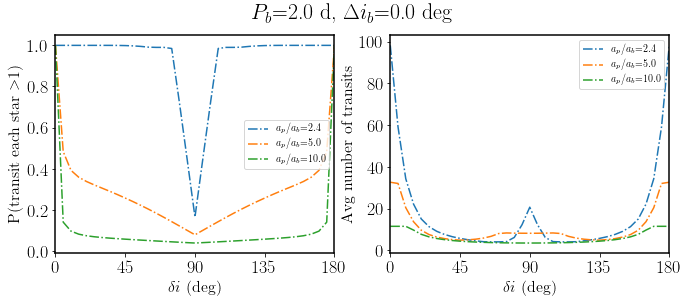

In [17]:
## want a plot of Ptran_binary vs. mutual_inc, for different ap/ab = 2.4, 5, 10
Pb = 2.0
ab = get_a(Pb, m1+m2)
ab1 = m2/(m1+m2) * ab
ab2 = m1/(m1+m2) * ab
ap = np.array([2.4, 5, 10]) * ab
d_ib = 0.*np.pi/180. # in rad
mutual_inclinations = np.linspace(0, 180, 37) * np.pi/180. # in rad
Pp = get_P(ap, m1+m2)
Ptran = np.zeros((len(Pp), len(mutual_inclinations)))
Ntran = np.zeros((len(Pp), len(mutual_inclinations)))

for zz in range(len(ap)):
    for ii in range(len(mutual_inclinations)):
        fone1 = get_f1(r1, ap[zz], mutual_inclinations[ii], d_ib)
        ftwo1 = get_f2(r1, ap[zz], mutual_inclinations[ii], d_ib)
        fone2 = get_f1(r2, ap[zz], mutual_inclinations[ii], d_ib)
        ftwo2 = get_f2(r2, ap[zz], mutual_inclinations[ii], d_ib)
        Delta_Omega1 = get_Delta_Omega1(ab1, ap[zz], fone1, ftwo1)
        Delta_Omega2 = get_Delta_Omega1(ab2, ap[zz], fone2, ftwo2)
        Tprec = get_Tprec(Pp[zz], m1, m2, ap[zz], ab, mutual_inclinations[ii])
        Omegadot = get_Omegadot(Tprec)
        del_Omega_prec = get_del_Omega_prec(Omegadot, Tobs)
        
        del_Omega1 = get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1, ap[zz], fone1, ftwo1)
        del_Omega2 = get_del_Omega1(Delta_Omega2, del_Omega_prec, ab2, ap[zz], fone2, ftwo2)
        
        vp = get_vel(Pp[zz], ap[zz])
        v1 = get_vel(Pb, ab1)
        v2 = get_vel(Pb, ab2)
        
        dl_same1 = get_dl_same(r1, vp, mutual_inclinations[ii], v1)
        dl_opp1 = get_dl_opp(r1, vp, mutual_inclinations[ii], v1)
        dl_same2 = get_dl_same(r2, vp, mutual_inclinations[ii], v2)
        dl_opp2 = get_dl_opp(r2, vp, mutual_inclinations[ii], v2)
        
        n1 = get_n1(Tobs, Pp[zz], Delta_Omega1, del_Omega_prec, Omegadot, ab1, ap[zz], ftwo1)
        n2 = get_n1(Tobs, Pp[zz], Delta_Omega2, del_Omega_prec, Omegadot, ab2, ap[zz], ftwo2)
        
        Pstar1 = get_Pstar1(dl_same1, dl_opp1, ab1)
        Pstar2 = get_Pstar1(dl_same2, dl_opp2, ab2)
        Pcross1 = get_Pcross1(del_Omega1)
        Pcross2 = get_Pcross1(del_Omega2)
#         print("{:.1f} {:.2f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
#             mutual_inclinations[ii]*180/np.pi, Tprec, Omegadot, float(n1), float(n2), 
#             float(Pstar1), float(Pstar2), float(Pcross1), float(Pcross2)))
        Ptran[zz, ii] = get_Ptran_binary(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        Ntran[zz, ii] = get_Ntransit_avg(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        
plt.figure(figsize=(11,4))
plt.subplot(121)
for zz in range(len(ap)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[zz,:], '-.',
            label="$a_p/a_b$={:.1f}".format(ap[zz]/ab))
plt.xlabel('$\delta i$ (deg)')
plt.xticks(np.arange(0, 182, step=45))
plt.ylabel('P(transit each star $>$1)')
plt.legend()
plt.xlim(0, 180)

plt.subplot(122)
for zz in range(len(ap)):
    plt.plot(mutual_inclinations*180/np.pi, Ntran[zz,:], '-.',
            label="$a_p/a_b$={:.1f}".format(ap[zz]/ab))
plt.xlabel('$\delta i$ (deg)')
plt.xticks(np.arange(0, 182, step=45))
plt.ylabel('Avg number of transits')
plt.legend()
plt.xlim(0, 180)

plt.suptitle("$P_b$={:.1f} d, $\Delta i_b$={:.1f} deg".format(Pb, d_ib*180/np.pi))

plt.show()

/Users/diana/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/Users/diana/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/Users/diana/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:113: RuntimeWarning: divide by zero encountered in double_scalars


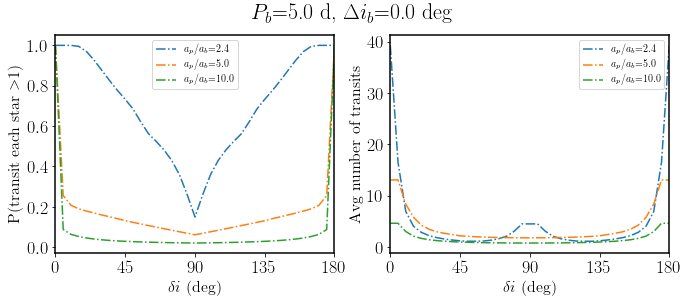

In [18]:
## want a plot of Ptran_binary vs. mutual_inc, for different ap/ab = 2.4, 5, 10
Pb = 5.0
ab = get_a(Pb, m1+m2)
ab1 = m2/(m1+m2) * ab
ab2 = m1/(m1+m2) * ab
ap = np.array([2.4, 5, 10]) * ab
d_ib = 0.*np.pi/180. # in rad
mutual_inclinations = np.linspace(0, 180, 37) * np.pi/180. # in rad
Pp = get_P(ap, m1+m2)
Ptran = np.zeros((len(Pp), len(mutual_inclinations)))
Ntran = np.zeros((len(Pp), len(mutual_inclinations)))

for zz in range(len(ap)):
    for ii in range(len(mutual_inclinations)):
        fone1 = get_f1(r1, ap[zz], mutual_inclinations[ii], d_ib)
        ftwo1 = get_f2(r1, ap[zz], mutual_inclinations[ii], d_ib)
        fone2 = get_f1(r2, ap[zz], mutual_inclinations[ii], d_ib)
        ftwo2 = get_f2(r2, ap[zz], mutual_inclinations[ii], d_ib)
        Delta_Omega1 = get_Delta_Omega1(ab1, ap[zz], fone1, ftwo1)
        Delta_Omega2 = get_Delta_Omega1(ab2, ap[zz], fone2, ftwo2)
        Tprec = get_Tprec(Pp[zz], m1, m2, ap[zz], ab, mutual_inclinations[ii])
        Omegadot = get_Omegadot(Tprec)
        del_Omega_prec = get_del_Omega_prec(Omegadot, Tobs)
        
        del_Omega1 = get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1, ap[zz], fone1, ftwo1)
        del_Omega2 = get_del_Omega1(Delta_Omega2, del_Omega_prec, ab2, ap[zz], fone2, ftwo2)
        
        vp = get_vel(Pp[zz], ap[zz])
        v1 = get_vel(Pb, ab1)
        v2 = get_vel(Pb, ab2)
        
        dl_same1 = get_dl_same(r1, vp, mutual_inclinations[ii], v1)
        dl_opp1 = get_dl_opp(r1, vp, mutual_inclinations[ii], v1)
        dl_same2 = get_dl_same(r2, vp, mutual_inclinations[ii], v2)
        dl_opp2 = get_dl_opp(r2, vp, mutual_inclinations[ii], v2)
        
        n1 = get_n1(Tobs, Pp[zz], Delta_Omega1, del_Omega_prec, Omegadot, ab1, ap[zz], ftwo1)
        n2 = get_n1(Tobs, Pp[zz], Delta_Omega2, del_Omega_prec, Omegadot, ab2, ap[zz], ftwo2)
        
        Pstar1 = get_Pstar1(dl_same1, dl_opp1, ab1)
        Pstar2 = get_Pstar1(dl_same2, dl_opp2, ab2)
        Pcross1 = get_Pcross1(del_Omega1)
        Pcross2 = get_Pcross1(del_Omega2)
#        print("{:.1f} {:.2f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
#            mutual_inclinations[ii]*180/np.pi, Tprec, Omegadot, float(n1), float(n2), 
#            float(Pstar1), float(Pstar2), float(Pcross1), float(Pcross2)))
        Ptran[zz, ii] = get_Ptran_binary(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        Ntran[zz, ii] = get_Ntransit_avg(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        
plt.figure(figsize=(11,4))
plt.subplot(121)
for zz in range(len(ap)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[zz,:], '-.',
            label="$a_p/a_b$={:.1f}".format(ap[zz]/ab))
plt.xlabel('$\delta i$ (deg)')
plt.xticks(np.arange(0, 182, step=45))
plt.ylabel('P(transit each star $>$1)')
plt.legend()
plt.xlim(0, 180)

plt.subplot(122)
for zz in range(len(ap)):
    plt.plot(mutual_inclinations*180/np.pi, Ntran[zz,:], '-.',
            label="$a_p/a_b$={:.1f}".format(ap[zz]/ab))
plt.xlabel('$\delta i$ (deg)')
plt.xticks(np.arange(0, 182, step=45))
plt.ylabel('Avg number of transits')
plt.legend()
plt.xlim(0, 180)

plt.suptitle("$P_b$={:.1f} d, $\Delta i_b$={:.1f} deg".format(Pb, d_ib*180/np.pi))

plt.show()

## Reproduce Figure 6, where Pb=2, 5 d and binary inc. varies ##

ic=13.742029238


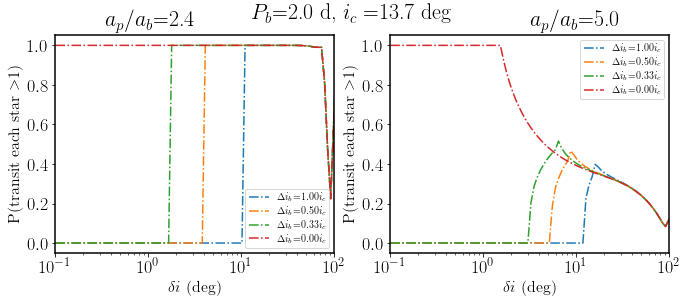

In [19]:
## want a plot of Ptran_binary vs. mutual_inc, for different ap/ab = 2.4, 5, 10
Pb = 2.
ab = get_a(Pb, m1+m2)
ab1 = m2/(m1+m2) * ab
ab2 = m1/(m1+m2) * ab
ap = np.array([2.4, 5., 10.]) * ab
i_c = np.arcsin((r1+r2)*r2au / ab)
print("ic={}".format(i_c*180/np.pi))
d_ib = np.array([1., 0.5, 1/3., 0])*i_c
mutual_inclinations = np.logspace(-1, np.log10(180), 100) * np.pi/180.
Tobs = 365*1.
Pp = get_P(ap, m1+m2)
Ptran = np.zeros((len(d_ib), len(Pp), len(mutual_inclinations)))
Ntran = np.zeros(Ptran.shape)

for kk in range(len(d_ib)):
    for zz in range(len(ap)):
        for ii in range(len(mutual_inclinations)):
            fone1 = get_f1(r1, ap[zz], mutual_inclinations[ii], d_ib[kk])
            ftwo1 = get_f2(r1, ap[zz], mutual_inclinations[ii], d_ib[kk])
            fone2 = get_f1(r2, ap[zz], mutual_inclinations[ii], d_ib[kk])
            ftwo2 = get_f2(r2, ap[zz], mutual_inclinations[ii], d_ib[kk])
            
            Delta_Omega1 = get_Delta_Omega1(ab1, ap[zz], fone1, ftwo1)
            Delta_Omega2 = get_Delta_Omega1(ab2, ap[zz], fone2, ftwo2)
            
            Tprec = get_Tprec(Pp[zz], m1, m2, ap[zz], ab, mutual_inclinations[ii])
            Omegadot = get_Omegadot(Tprec)
            del_Omega_prec = get_del_Omega_prec(Omegadot, Tobs)
            del_Omega1 = get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1, ap[zz], fone1, ftwo1)
            del_Omega2 = get_del_Omega1(Delta_Omega2, del_Omega_prec, ab2, ap[zz], fone2, ftwo2)
            
            vp = get_vel(Pp[zz], ap[zz])
            v1 = get_vel(Pb, ab1)
            v2 = get_vel(Pb, ab2)
            
            dl_same1 = get_dl_same(r1, vp, mutual_inclinations[ii], v1)
            dl_opp1 = get_dl_opp(r1, vp, mutual_inclinations[ii], v1)
            dl_same2 = get_dl_same(r2, vp, mutual_inclinations[ii], v2)
            dl_opp2 = get_dl_opp(r2, vp, mutual_inclinations[ii], v2)
            
            n1 = get_n1(Tobs, Pp[zz], Delta_Omega1, del_Omega_prec, Omegadot, ab1, ap[zz], ftwo1)
            n2 = get_n1(Tobs, Pp[zz], Delta_Omega2, del_Omega_prec, Omegadot, ab2, ap[zz], ftwo2)
            Pstar1 = get_Pstar1(dl_same1, dl_opp1, ab1)
            Pstar2 = get_Pstar1(dl_same2, dl_opp2, ab2)
            Pcross1 = get_Pcross1(del_Omega1)
            Pcross2 = get_Pcross1(del_Omega2)
            Ptran[kk, zz, ii] = get_Ptran_binary(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
            ipc1 = get_ipc1(d_ib[kk], ab1, r1, ap[zz])
            ipc2 = get_ipc1(d_ib[kk], ab2, r2, ap[zz])
#             if zz==0 and ii%4==0:
#                 print("{:.1f} {:.2f} {:.2f} {:.2f} {:.2f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
#                     mutual_inclinations[ii]*180/np.pi, d_ib[kk]*180/np.pi, ipc1*180/np.pi, ipc2*180/np.pi, Tprec, Omegadot, 
#                     float(del_Omega1)*180/np.pi, float(del_Omega2)*180/np.pi,float(n1), float(n2), 
#                     float(Pstar1), float(Pstar2), float(Pcross1), float(Pcross2)))

            Ptran[kk, zz, ii] = get_Ptran_winc(Ptran[kk,zz,ii], mutual_inclinations[ii], ipc1, ipc2)
    

plt.figure(figsize=(11,4))
zz=0
plt.subplot(121)
for kk in range(len(d_ib)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[kk, zz,:], '-.',
            label="$\Delta i_b$={:.2f}$i_c$".format(d_ib[kk]/i_c))
plt.xlabel('$\delta i$ (deg)')
plt.title('$a_p/a_b$={:.1f}'.format(ap[zz]/ab), ha='right')
plt.xscale('log')
plt.ylabel('P(transit each star $>$1)')
plt.legend()
plt.xlim(0, 100)

plt.subplot(122)
zz=1
for kk in range(len(d_ib)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[kk, zz,:], '-.',
            label="$\Delta i_b$={:.2f}$i_c$".format(d_ib[kk]/i_c))
plt.xlabel('$\delta i$ (deg)')
plt.xscale('log')
plt.ylabel('P(transit each star $>$1)')
plt.title('$a_p/a_b$={:.1f}'.format(ap[zz]/ab), ha='left')
plt.legend()
plt.xlim(0, 100)
plt.suptitle('$P_b$={:.1f} d, $i_c=${:.1f} deg'.format(Pb, i_c*180/np.pi))

In [20]:
print(Pb, d_ib*180/np.pi, ap[0]/ab, ap[0]/ab1)
print("ipc1=",(get_ipc1(d_ib[:], ab1, r1, ap[0]) * 180/np.pi))
print("ipc2=",(get_ipc1(d_ib[:], ab2, r2, ap[0]) * 180/np.pi))
print(r1*r2au/ab1)
print((abs(d_ib[:]) - np.arcsin((ab1*np.sin(d_ib[:])+r1*r2au)/ap[0]))*180/np.pi)

(2.0, array([13.74202924,  6.87101462,  4.58067641,  0.        ]), 2.4, 4.8)
('ipc1=', array([ 8.06162159,  2.60348378,  0.78906495, -2.8367121 ]))
('ipc2=', array([ 8.06162159,  2.60348378,  0.78906495, -2.8367121 ]))
0.237550760764
[ 8.06162159  2.60348378  0.78906495 -2.8367121 ]


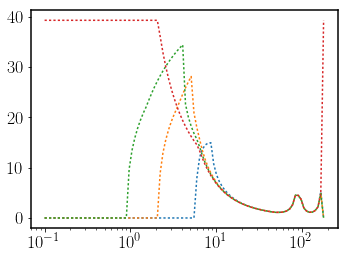

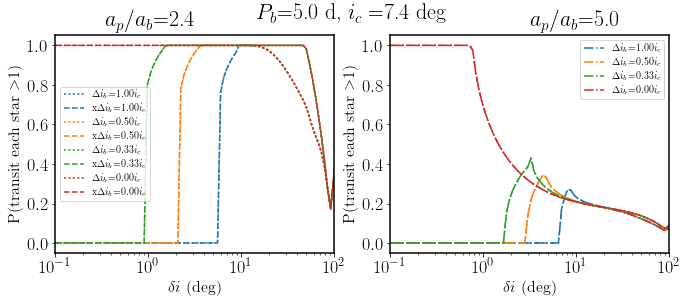

In [21]:
## want a plot of Ptran_binary vs. mutual_inc, for different ap/ab = 2.4, 5, 10
Pb = 5.
ab = get_a(Pb, m1+m2)
ab1 = m2/(m1+m2) * ab
ab2 = m1/(m1+m2) * ab
ap = np.array([2.4, 5., 10.]) * ab
i_c = np.arcsin((r1+r2)*r2au / ab)
d_ib = np.array([1., 0.5, 1/3., 0])*i_c
mutual_inclinations = np.logspace(-1, np.log10(180), 100) * np.pi/180.
Tobs = 365*1.
Pp = get_P(ap, m1+m2)
Ptran = np.zeros((len(d_ib), len(Pp), len(mutual_inclinations)))
Ntran = np.zeros(Ptran.shape)
Pcross1 = np.zeros(Ptran.shape)
Pcross2 = np.zeros(Ptran.shape)
Pstar1 = np.zeros(Ptran.shape)
Pstar2 = np.zeros(Ptran.shape)
del_Omegas = np.zeros(Ptran.shape)
for kk in range(len(d_ib)):
    for zz in range(len(ap)):
        for ii in range(len(mutual_inclinations)):
            fone1 = get_f1(r1, ap[zz], mutual_inclinations[ii], d_ib[kk])
            ftwo1 = get_f2(r1, ap[zz], mutual_inclinations[ii], d_ib[kk])
            fone2 = get_f1(r2, ap[zz], mutual_inclinations[ii], d_ib[kk])
            ftwo2 = get_f2(r2, ap[zz], mutual_inclinations[ii], d_ib[kk])
            
            Delta_Omega1 = get_Delta_Omega1(ab1, ap[zz], fone1, ftwo1)
            Delta_Omega2 = get_Delta_Omega1(ab2, ap[zz], fone2, ftwo2)
            
            Tprec = get_Tprec(Pp[zz], m1, m2, ap[zz], ab, mutual_inclinations[ii])
            Tprec2 = get_Tprec2(Pp[zz], Pb, m1, m2, mutual_inclinations[ii])
#             if abs(Tprec-Tprec2)>1e-4:
#                 print(Tprec, Tprec2, Pp[zz], Pb, mutual_inclinations[ii]*180/np.pi)
            Omegadot = get_Omegadot(Tprec)
            del_Omega_prec = get_del_Omega_prec(Omegadot, Tobs)
            del_Omega1 = get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1, ap[zz], fone1, ftwo1)
            del_Omega2 = get_del_Omega1(Delta_Omega2, del_Omega_prec, ab2, ap[zz], fone2, ftwo2)
            
            del_Omegas[kk,zz,ii] = del_Omega1
            vp = get_vel(Pp[zz], ap[zz])
            v1 = get_vel(Pb, ab1)
            v2 = get_vel(Pb, ab2)
            
            dl_same1 = get_dl_same(r1, vp, mutual_inclinations[ii], v1)
            dl_opp1 = get_dl_opp(r1, vp, mutual_inclinations[ii], v1)
            dl_same2 = get_dl_same(r2, vp, mutual_inclinations[ii], v2)
            dl_opp2 = get_dl_opp(r2, vp, mutual_inclinations[ii], v2)
            
            n1 = get_n1(Tobs, Pp[zz], Delta_Omega1, del_Omega_prec, Omegadot, ab1, ap[zz], ftwo1)
            n2 = get_n1(Tobs, Pp[zz], Delta_Omega2, del_Omega_prec, Omegadot, ab2, ap[zz], ftwo2)
            Pstar1[kk,zz,ii] = get_Pstar1(dl_same1, dl_opp1, ab1)
            Pstar2[kk,zz,ii] = get_Pstar1(dl_same2, dl_opp2, ab2)
            Pcross1[kk,zz,ii] = get_Pcross1(del_Omega1)
            Pcross2[kk,zz,ii] = get_Pcross1(del_Omega2)
            Ptran[kk, zz, ii] = get_Ptran_binary(Pcross1[kk,zz,ii], Pcross2[kk,zz,ii], 
                                                 Pstar1[kk,zz,ii], Pstar2[kk,zz,ii], n1, n2)
            Ntran[kk, zz, ii] = get_Ntransit_avg(Pcross1[kk,zz,ii], Pcross2[kk,zz,ii], 
                                                 Pstar1[kk,zz,ii], Pstar2[kk,zz,ii], n1, n2)
            ipc1 = get_ipc1(d_ib[kk], ab1, r1, ap[zz])
            ipc2 = get_ipc1(d_ib[kk], ab2, r2, ap[zz])
#             if zz==0 and ii%4==0:
#                 print("{:.1f} {:.2f} {:.2f} {:.2f} {:.2f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
#                     mutual_inclinations[ii]*180/np.pi, d_ib[kk]*180/np.pi, ipc1*180/np.pi, ipc2*180/np.pi, Tprec, Omegadot, 
#                     float(del_Omega1)*180/np.pi, float(del_Omega2)*180/np.pi,float(n1), float(n2), 
#                     float(Pstar1), float(Pstar2), float(Pcross1), float(Pcross2)))
#            Ptran[kk, zz, ii] = get_Ptran_winc(Ptran[kk,zz,ii], mutual_inclinations[ii], ipc1, ipc2)
    

zz=0
plt.figure(figsize=(5.5, 4))
for kk in range(len(d_ib)):
    plt.plot(mutual_inclinations*180/np.pi, Ntran[kk, zz,:], ':', color='C{}'.format(kk),
            label="$\Delta i_b$={:.2f}$i_c$".format(d_ib[kk]/i_c))
plt.xscale('log')

plt.figure(figsize=(11,4))
plt.subplot(121)
for kk in range(len(d_ib)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[kk, zz,:], ':', color='C{}'.format(kk),
            label="$\Delta i_b$={:.2f}$i_c$".format(d_ib[kk]/i_c))
    plt.plot(mutual_inclinations*180/np.pi, Pcross1[kk, zz,:], '--', color='C{}'.format(kk),
            label="x$\Delta i_b$={:.2f}$i_c$".format(d_ib[kk]/i_c))
#     plt.plot(mutual_inclinations*180/np.pi, Pstar1[kk, zz,:], 'x', color='C{}'.format(kk),
#             label="x$\Delta i_b$={:.2f}$i_c$".format(d_ib[kk]/i_c))
plt.xlabel('$\delta i$ (deg)')
plt.title('$a_p/a_b$={:.1f}'.format(ap[zz]/ab), ha='right')
plt.xscale('log')
plt.ylabel('P(transit each star $>$1)')
plt.legend()
plt.xlim(0, 100)

plt.subplot(122)
zz=1
for kk in range(len(d_ib)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[kk, zz,:], '-.',
            label="$\Delta i_b$={:.2f}$i_c$".format(d_ib[kk]/i_c))
    plt.plot(mutual_inclinations*180/np.pi, Pcross1[kk,zz,:], '--', color='C{}'.format(kk),
            )
plt.xlabel('$\delta i$ (deg)')
plt.xscale('log')
plt.ylabel('P(transit each star $>$1)')
plt.title('$a_p/a_b$={:.1f}'.format(ap[zz]/ab), ha='left')
plt.legend()
plt.xlim(0, 100)
plt.suptitle('$P_b$={:.1f} d, $i_c=${:.1f} deg'.format(Pb, i_c*180/np.pi))

In [22]:
print(Pb, d_ib*180/np.pi, ap[0]/ab, ap[0]/ab1)
print("ipc1=",(get_ipc1(d_ib[:], ab1, r1, ap[0]) * 180/np.pi))
print("ipc2=",(get_ipc1(d_ib[:], ab2, r2, ap[0]) * 180/np.pi))
print(r1, r1*r2au/ap[0], r1*r2au/ab1, ab1/ap[0], 1/2.4)
print(d_ib, np.arcsin((ab1*np.sin(d_ib[:])+r1*r2au)/ap[0]))
print((abs(d_ib[:]) - np.arcsin((ab1*np.sin(d_ib[:])+r1*r2au)/ap[0]))*180/np.pi)

(5.0, array([7.40963716, 3.70481858, 2.46987905, 0.        ]), 2.4, 4.8)
('ipc1=', array([ 4.32940327,  1.39351712,  0.41566502, -1.53956044]))
('ipc2=', array([ 4.32940327,  1.39351712,  0.41566502, -1.53956044]))
(1.0, 0.026867165410597027, 0.12896239397086573, 0.20833333333333334, 0.4166666666666667)
(array([0.12932256, 0.06466128, 0.04310752, 0.        ]), array([0.05376022, 0.04033982, 0.0358528 , 0.0268704 ]))
[ 4.32940327  1.39351712  0.41566502 -1.53956044]


# Reproduce Figure 7, top panel #

(0, 1)

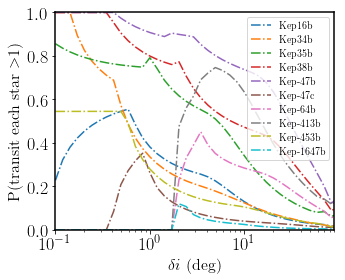

In [23]:
## want a plot of Ptran_binary vs. mutual_inc, for different ap/ab = 2.4, 5, 10
Tobs = 365*4.

ab = np.array([0.22, 0.23, 0.18, 0.15, 0.084, 0.084, 0.17, 0.10, 0.18, 0.13])
m1 = np.array([0.69, 1.05, 0.89, 0.95, 1.04, 1.04, 1.53, 0.82, 0.93, 1.22])
m2 = np.array([0.20, 1.02, 0.81, 0.25, 0.36, 0.36, 0.41, 0.54, 0.19, 0.97])
r1 = np.array([0.65, 1.16, 1.03, 1.76, 0.96, 0.96, 1.73, 0.78, 0.83, 1.79])
r2 = np.array([0.23, 1.09, 0.79, 0.27, 0.35, 0.35, 0.38, 0.48, 0.21, 0.97])
ecc = np.array([0.16, 0.52, 0.14, 0.10, 0.023, 0.023, 0.21, 0.037, 0.051, 0.16])
label = ['Kep16b', 'Kep34b', 'Kep35b', 'Kep38b', 'Kep-47b', 'Kep-47c', 'Kep-64b', 'Kep-413b', 'Kep-453b', 'Kep-1647b']
Pb = get_P(ab, m1+m2)
ab1 = m2/(m1+m2) * ab
ab2 = m1/(m1+m2) * ab
i_c = np.arcsin((r1+r2)*r2au / ab)
d_ib = np.array([90.34, 89.86, 90.42, 89.27, 89.34, 89.34, 87.36, 87.59, 90.28, 87.92])
d_ib = abs(90-d_ib) * np.pi/180.

pcrit = get_Pcrit(Pb, m1, m2, ecc)
acrit = get_a(pcrit, m1+m2)

ap = np.array([0.70, 1.09, 0.60, 0.46, 0.30, 0.99, 0.63, 0.36, 0.79, 2.72])
mutual_inclinations = np.logspace(-1, 2, 40)*np.pi/180.

Pp = get_P(ap, m1+m2)
Ptran = np.zeros((len(m1), len(mutual_inclinations)))
Ntran = np.zeros(Ptran.shape)

for kk in range(len(m1)):
    for ii in range(len(mutual_inclinations)):
        fone1 = get_f1(r1[kk], ap[kk], mutual_inclinations[ii], d_ib[kk])
        ftwo1 = get_f2(r1[kk], ap[kk], mutual_inclinations[ii], d_ib[kk])
        fone2 = get_f1(r2[kk], ap[kk], mutual_inclinations[ii], d_ib[kk])
        ftwo2 = get_f2(r2[kk], ap[kk], mutual_inclinations[ii], d_ib[kk])

        Delta_Omega1 = get_Delta_Omega1(ab1[kk], ap[kk], fone1, ftwo1)
        Delta_Omega2 = get_Delta_Omega1(ab2[kk], ap[kk], fone2, ftwo2)

        Tprec = get_Tprec(Pp[kk], m1[kk], m2[kk], ap[kk], ab[kk], mutual_inclinations[ii])
        Omegadot = get_Omegadot(Tprec)
        del_Omega_prec = get_del_Omega_prec(Omegadot, Tobs)
        del_Omega1 = get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1[kk], ap[kk], fone1, ftwo1)
        del_Omega2 = get_del_Omega1(Delta_Omega2, del_Omega_prec, ab2[kk], ap[kk], fone2, ftwo2)

        vp = get_vel(Pp[kk], ap[kk])
        v1 = get_vel(Pb[kk], ab1[kk])
        v2 = get_vel(Pb[kk], ab2[kk])

        dl_same1 = get_dl_same(r1[kk], vp, mutual_inclinations[ii], v1)
        dl_opp1 = get_dl_opp(r1[kk], vp, mutual_inclinations[ii], v1)
        dl_same2 = get_dl_same(r2[kk], vp, mutual_inclinations[ii], v2)
        dl_opp2 = get_dl_opp(r2[kk], vp, mutual_inclinations[ii], v2)

        n1 = get_n1(Tobs, Pp[kk], Delta_Omega1, del_Omega_prec, Omegadot, ab1[kk], ap[kk], ftwo1)
        n2 = get_n1(Tobs, Pp[kk], Delta_Omega2, del_Omega_prec, Omegadot, ab2[kk], ap[kk], ftwo2)
        Pstar1 = get_Pstar1(dl_same1, dl_opp1, ab1[kk])
        Pstar2 = get_Pstar1(dl_same2, dl_opp2, ab2[kk])
        Pcross1 = get_Pcross1(del_Omega1)
        Pcross2 = get_Pcross1(del_Omega2)
        Ptran[kk, ii] = get_Ptran_star1(Pcross1, Pstar1, n1)#binary(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        ipc1 = get_ipc1(d_ib[kk], ab1[kk], r1[kk], ap[kk])
        ipc2 = get_ipc1(d_ib[kk], ab2[kk], r2[kk], ap[kk])
#             if zz==0 and ii%4==0:
#                 print("{:.1f} {:.2f} {:.2f} {:.2f} {:.2f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
#                     mutual_inclinations[ii]*180/np.pi, d_ib[kk]*180/np.pi, ipc1*180/np.pi, ipc2*180/np.pi, Tprec, Omegadot, 
#                     float(del_Omega1)*180/np.pi, float(del_Omega2)*180/np.pi,float(n1), float(n2), 
#                     float(Pstar1), float(Pstar2), float(Pcross1), float(Pcross2)))

        Ptran[kk, ii] = get_Ptran_winc(Ptran[kk,ii], mutual_inclinations[ii], ipc1, ipc1)#ipc2)
    

plt.figure(figsize=(5,4))
plt.subplot(111)
for kk in range(len(m1)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[kk,:], '-.',
            label="{}".format(label[kk]))
plt.xlabel('$\delta i$ (deg)')
plt.xscale('log')
plt.ylabel('P(transit each star $>$1)')
plt.legend()
plt.xlim(0, 90)
plt.ylim(0,1)

# Reproduce Figure 7, bottom panel #

(0, 1)

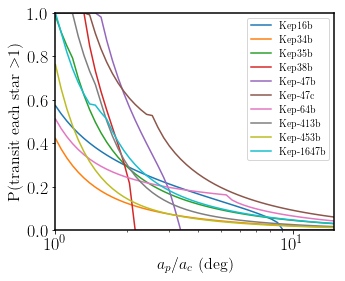

In [24]:
## want a plot of Ptran_binary vs. mutual_inc, for different ap/ab = 2.4, 5, 10
Tobs = 365*4.

ab = np.array([0.22, 0.23, 0.18, 0.15, 0.084, 0.084, 0.17, 0.10, 0.18, 0.13])
m1 = np.array([0.69, 1.05, 0.89, 0.95, 1.04, 1.04, 1.53, 0.82, 0.93, 1.22])
m2 = np.array([0.20, 1.02, 0.81, 0.25, 0.36, 0.36, 0.41, 0.54, 0.19, 0.97])
r1 = np.array([0.65, 1.16, 1.03, 1.76, 0.96, 0.96, 1.73, 0.78, 0.83, 1.79])
r2 = np.array([0.23, 1.09, 0.79, 0.27, 0.35, 0.35, 0.38, 0.48, 0.21, 0.97])
ecc = np.array([0.16, 0.52, 0.14, 0.10, 0.023, 0.023, 0.21, 0.037, 0.051, 0.16])
label = ['Kep16b', 'Kep34b', 'Kep35b', 'Kep38b', 'Kep-47b', 'Kep-47c', 'Kep-64b', 'Kep-413b', 'Kep-453b', 'Kep-1647b']
Pb = get_P(ab, m1+m2)
ab1 = m2/(m1+m2) * ab
ab2 = m1/(m1+m2) * ab
i_c = np.arcsin((r1+r2)*r2au / ab)
d_ib = np.array([90.34, 89.86, 90.42, 89.27, 89.34, 89.34, 87.36, 87.59, 90.28, 87.92])
d_ib = abs(90-d_ib) * np.pi/180.

pcrit = get_Pcrit(Pb, m1, m2, ecc)
acrit = get_a(pcrit, m1+m2)
mutual_inclinations = np.array([0.31, 1.86, 1.07, 0.18, 0.27, 1.16, 2.81, 4.07, 2.30, 2.99])*np.pi/180.

ap_ac = np.logspace(0, np.log10(15), 50)
#mutual_inclinations = np.logspace(-1, 2, 40)*np.pi/180.

#Pp = get_P(ap, m1+m2)
Ptran = np.zeros((len(m1), len(ap_ac)))
Ntran = np.zeros(Ptran.shape)

for kk in range(len(m1)):
    for ii in range(len(ap_ac)):
        ap = ap_ac[ii] * acrit[kk]
        Pp = get_P(ap, m1[kk]+m2[kk])
        
        fone1 = get_f1(r1[kk], ap, mutual_inclinations[kk], d_ib[kk])
        ftwo1 = get_f2(r1[kk], ap, mutual_inclinations[kk], d_ib[kk])
        fone2 = get_f1(r2[kk], ap, mutual_inclinations[kk], d_ib[kk])
        ftwo2 = get_f2(r2[kk], ap, mutual_inclinations[kk], d_ib[kk])

        Delta_Omega1 = get_Delta_Omega1(ab1[kk], ap, fone1, ftwo1)
        Delta_Omega2 = get_Delta_Omega1(ab2[kk], ap, fone2, ftwo2)

        Tprec = get_Tprec(Pp, m1[kk], m2[kk], ap, ab[kk], mutual_inclinations[kk])
        Omegadot = get_Omegadot(Tprec)
        del_Omega_prec = get_del_Omega_prec(Omegadot, Tobs)
        del_Omega1 = get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1[kk], ap, fone1, ftwo1)
        del_Omega2 = get_del_Omega1(Delta_Omega2, del_Omega_prec, ab2[kk], ap, fone2, ftwo2)

        vp = get_vel(Pp, ap)
        v1 = get_vel(Pb[kk], ab1[kk])
        v2 = get_vel(Pb[kk], ab2[kk])

        dl_same1 = get_dl_same(r1[kk], vp, mutual_inclinations[kk], v1)
        dl_opp1 = get_dl_opp(r1[kk], vp, mutual_inclinations[kk], v1)
        dl_same2 = get_dl_same(r2[kk], vp, mutual_inclinations[kk], v2)
        dl_opp2 = get_dl_opp(r2[kk], vp, mutual_inclinations[kk], v2)

        n1 = get_n1(Tobs, Pp, Delta_Omega1, del_Omega_prec, Omegadot, ab1[kk], ap, ftwo1)
        n2 = get_n1(Tobs, Pp, Delta_Omega2, del_Omega_prec, Omegadot, ab2[kk], ap, ftwo2)
        Pstar1 = get_Pstar1(dl_same1, dl_opp1, ab1[kk])
        Pstar2 = get_Pstar1(dl_same2, dl_opp2, ab2[kk])
        Pcross1 = get_Pcross1(del_Omega1)
        Pcross2 = get_Pcross1(del_Omega2)
        Ptran[kk, ii] = get_Ptran_star1(Pcross1, Pstar1, n1)#binary(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        ipc1 = get_ipc1(d_ib[kk], ab1[kk], r1[kk], ap)
        ipc2 = get_ipc1(d_ib[kk], ab2[kk], r2[kk], ap)
#             if zz==0 and ii%4==0:
#                 print("{:.1f} {:.2f} {:.2f} {:.2f} {:.2f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
#                     mutual_inclinations[ii]*180/np.pi, d_ib[kk]*180/np.pi, ipc1*180/np.pi, ipc2*180/np.pi, Tprec, Omegadot, 
#                     float(del_Omega1)*180/np.pi, float(del_Omega2)*180/np.pi,float(n1), float(n2), 
#                     float(Pstar1), float(Pstar2), float(Pcross1), float(Pcross2)))

        Ptran[kk, ii] = get_Ptran_winc(Ptran[kk,ii], mutual_inclinations[kk], ipc1, ipc1)#ipc2)
    

plt.figure(figsize=(5,4))
plt.subplot(111)
for kk in range(len(m1)):
    plt.plot(ap_ac, Ptran[kk,:], '-',
            label="{}".format(label[kk]))
plt.xlabel('$a_p/a_c$ (deg)')
plt.xscale('log')
plt.ylabel('P(transit each star $>$1)')
plt.legend()
plt.xlim(0, 15)
plt.ylim(0, 1)

## Apply geometric transit probability to simulated CBP ##

(10.13, array([55.29068699]), 1.0, 1.0, 1.0, 1.0)


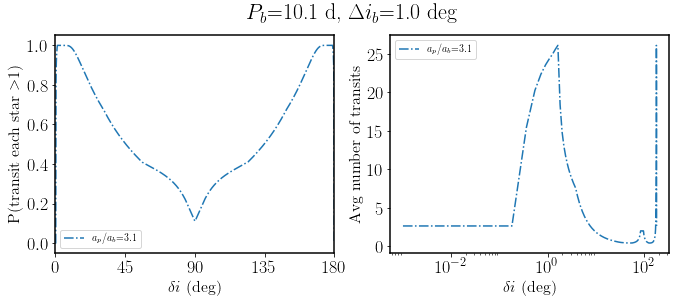

In [27]:
## want a plot of Ptran_binary vs. mutual_inc, for different ap/ab = 2.4, 5, 10
m1, m2 = 1.0, 1.0
r1, r2 = 1.0, 1.0
Pb = 10.13
ab = get_a(Pb, m1+m2)
ab1 = m2/(m1+m2) * ab
ab2 = m1/(m1+m2) * ab

ap = np.array([3.1])*ab#np.array([2.4, 5, 10]) * ab
d_ib = np.pi/2. - 89.*np.pi/180. # in rad
#mutual_inclinations = np.sort(np.append(np.linspace(0, np.pi, 10), d_ib))#np.linspace(0, 180, 37) * np.pi/180. # in rad
mutual_inclinations = np.linspace(1e-3, 180, 1000) * np.pi/180. # in rad
Pp = get_P(ap, m1+m2)
Ptran = np.zeros((len(Pp), len(mutual_inclinations)))
Ntran = np.zeros((len(Pp), len(mutual_inclinations)))
Tobs=4*365.
print(Pb, Pp, m1, m2, r1, r2)

for zz in range(len(ap)):
    for ii in range(len(mutual_inclinations)):
        fone1 = get_f1(r1, ap[zz], mutual_inclinations[ii], d_ib)
        ftwo1 = get_f2(r1, ap[zz], mutual_inclinations[ii], d_ib)
        fone2 = get_f1(r2, ap[zz], mutual_inclinations[ii], d_ib)
        ftwo2 = get_f2(r2, ap[zz], mutual_inclinations[ii], d_ib)
        Delta_Omega1 = get_Delta_Omega1(ab1, ap[zz], fone1, ftwo1)
        Delta_Omega2 = get_Delta_Omega1(ab2, ap[zz], fone2, ftwo2)
        Tprec = get_Tprec(Pp[zz], m1, m2, ap[zz], ab, mutual_inclinations[ii])
        Omegadot = get_Omegadot(Tprec)
        del_Omega_prec = get_del_Omega_prec(Omegadot, Tobs)
        
        del_Omega1 = get_del_Omega1(Delta_Omega1, del_Omega_prec, ab1, ap[zz], fone1, ftwo1)
        del_Omega2 = get_del_Omega1(Delta_Omega2, del_Omega_prec, ab2, ap[zz], fone2, ftwo2)
        
        vp = get_vel(Pp[zz], ap[zz])
        v1 = get_vel(Pb, ab1)
        v2 = get_vel(Pb, ab2)
        
        dl_same1 = get_dl_same(r1, vp, mutual_inclinations[ii], v1)
        dl_opp1 = get_dl_opp(r1, vp, mutual_inclinations[ii], v1)
        dl_same2 = get_dl_same(r2, vp, mutual_inclinations[ii], v2)
        dl_opp2 = get_dl_opp(r2, vp, mutual_inclinations[ii], v2)
        
        n1 = get_n1(Tobs, Pp[zz], Delta_Omega1, del_Omega_prec, Omegadot, ab1, ap[zz], ftwo1)
        n2 = get_n1(Tobs, Pp[zz], Delta_Omega2, del_Omega_prec, Omegadot, ab2, ap[zz], ftwo2)
        
        Pstar1 = get_Pstar1(dl_same1, dl_opp1, ab1)
        Pstar2 = get_Pstar1(dl_same2, dl_opp2, ab2)
        Pcross1 = get_Pcross1(del_Omega1)
        Pcross2 = get_Pcross1(del_Omega2)
#         print("{:.1f} {:.2f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(
#             mutual_inclinations[ii]*180/np.pi, Tprec, Omegadot, float(n1), float(n2), 
#             float(Pstar1), float(Pstar2), float(Pcross1), float(Pcross2)))
        Ptran[zz, ii] = get_Ptran_binary(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        Ntran[zz, ii] = n1*Pstar1#get_Ntransit_avg(Pcross1, Pcross2, Pstar1, Pstar2, n1, n2)
        
plt.figure(figsize=(11,4))
plt.subplot(121)
for zz in range(len(ap)):
    plt.plot(mutual_inclinations*180/np.pi, Ptran[zz,:], '-.',
            label="$a_p/a_b$={:.1f}".format(ap[zz]/ab))
plt.xlabel('$\delta i$ (deg)')
plt.xticks(np.arange(0, 182, step=45))
plt.ylabel('P(transit each star $>$1)')
plt.legend()
plt.xlim(0, 180)

plt.subplot(122)
for zz in range(len(ap)):
    plt.plot(mutual_inclinations*180/np.pi, Ntran[zz,:], '-.',
            label="$a_p/a_b$={:.1f}".format(ap[zz]/ab))
plt.xlabel('$\delta i$ (deg)')
plt.xticks(np.arange(0, 182, step=45))
plt.ylabel('Avg number of transits')
plt.legend()
plt.xscale('log')
#plt.xlim(0, 180)

plt.suptitle("$P_b$={:.1f} d, $\Delta i_b$={:.1f} deg".format(Pb, d_ib*180/np.pi))

plt.show()

# np.savez('validate_Ntran_mutual_inclination_analyticPp55.3.npz', 
#          mutual_inclinations=mutual_inclinations, Ntran=Ntran,
#          Ptran=Ptran)


## Make Hierarchical Diagram Schematic ##

(0.0, 1.1, 0.0, 1.1)

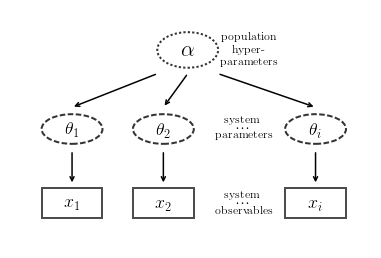

In [28]:
from matplotlib.patches import Ellipse, Rectangle

alpha = Ellipse(xy=[0.5, 0.9], width=0.2, height=0.18, angle=0)

xcoords = np.array([1.2, 4.2, 9.2])/10.
xs = [Rectangle(xy=[i-0.1, 0.05], width=0.2, height=0.15, angle=0) for i in xcoords]
x_labels = [r'${x_1}$', r'${x_2}$', r'${x_i}$']

thetas = [Ellipse(xy=[i, 0.5], width=0.2, height=0.15, angle=0) for i in xcoords]
theta_labels = [r'${\theta_1}$', r'${\theta_2}$', r'${\theta_i}$']

fig, ax = plt.subplots(figsize=(6,4))#,subplot_kw={'aspect': 'equal'})
ax.add_artist(alpha)
alpha.set_edgecolor('0.2')
alpha.set_facecolor('w')
alpha.set_linestyle(':')
alpha.set_linewidth(2)
ax.annotate(r'${\alpha}$', (0.5, 0.9), color='k', weight='bold', ha='center',
           va='center', fontsize=22)
for i,e in enumerate(xs):
    ax.add_artist(e)
#     ax.arrow(xcoords[i], 0.2, 0, 0.1, color='0.1', width=0.005,
#           head_width=0.01, )
    ax.annotate("",
                 xy=(xcoords[i], 0.22), #xycoords='data',
                 xytext=(xcoords[i], 0.39), #textcoords='data',
                 arrowprops=dict(arrowstyle="->", lw=1.5))#, color="0.1",
# #                                shrinkA=5, shrinkB=5, fc='k',
# #                                patchA=None, patchB=None,
# #                                connectionstyle=connectionstyle,
#                                 ),
#                 )
    e.set_clip_box(ax.bbox)
    e.set_edgecolor('0.3')
    e.set_facecolor('w')
    e.set_linewidth(2)
    e.set_linestyle('-')
    ax.annotate(x_labels[i], (xcoords[i], 0.11), color='k', weight='bold',
               ha='center', va='center', fontsize=18)

for i,e in enumerate(thetas):
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_edgecolor('0.2')
    e.set_facecolor('w')
    e.set_linewidth(2)
    e.set_linestyle('--')
    ax.annotate(theta_labels[i], (xcoords[i], 0.48), color='k', weight='bold',
               ha='center', va='center', fontsize=18)
    ax.annotate("",
                 xy=(xcoords[i], 0.61), #xycoords='data',
                 xytext=(0.4+(i/10.), 0.78), #textcoords='data',
                 arrowprops=dict(arrowstyle="->", lw=1.5))#, color="0.1",
ax.annotate("...", (0.66, 0.5), fontsize=20, weight='extra bold')
ax.annotate("...", (0.66, 0.12), fontsize=20, weight='extra bold')

ax.annotate("population\nhyper-\nparameters", (0.7, 0.9), fontsize=12,
           va='center', ha='center')
ax.annotate("system", (0.62, 0.55), fontsize=12,
           va='center', ha='left')
ax.annotate("parameters", (0.59, 0.47), fontsize=12, va='center', ha='left')
ax.annotate("system", (0.62, 0.17), fontsize=12,
           va='center', ha='left')
ax.annotate("observables", (0.59, 0.08), fontsize=12, va='center', ha='left')

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
plt.axis('off')
#plt.savefig('hierarchical_diagram.pdf', bbox_inches='tight')

## Look at relationship between Ip, Ib, dOmega, dI ##

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


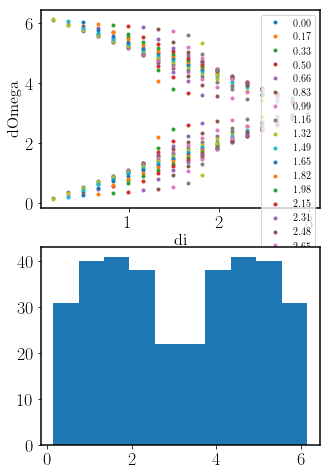

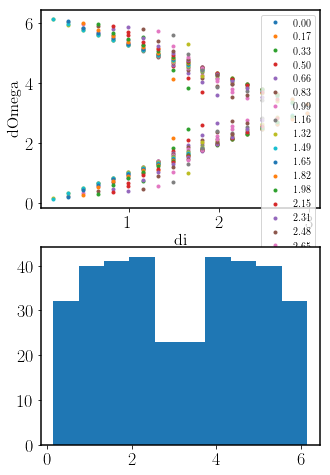

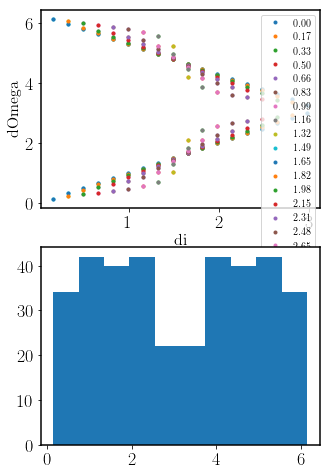

In [479]:
def cosdi(ib, ip, dOmega):
    return np.cos(dOmega) * np.sin(ib) * np.sin(ip) + np.cos(ib) * np.cos(ip)

def cosdOmega(ib, ip, di):
    return (np.cos(di) - np.cos(ib) * np.cos(ip)) / (np.sin(ib)*np.sin(ip))

def get_Ip(di0, ib, dOmega):
    iptest = np.linspace(0, np.pi, 10000)
    ditest = cosdi(ib, iptest, dOmega)
    cosdi0 = np.cos(di0)
    ind = np.argmin(abs(cosdi0-ditest))
    if abs(cosdi0-ditest[ind])<1e-3:
        return iptest[ind]
    else:
        return np.nan

def test(Ib):
    np.random.seed(0)
    Ip = np.linspace(0, np.pi, 20)
    dOmega = np.linspace(0, 2*np.pi, 40)
#     _firstquad = np.random.normal(0, np.pi/4., size=200)
#     dOmega = np.unique(np.hstack((_firstquad[_firstquad>0.], np.random.normal(np.pi, np.pi/4., size=200),
#            2*np.pi-_firstquad[_firstquad>0.])).ravel())[::10]
    di = np.zeros((Ip.shape[0], dOmega.shape[0]))
    plt.figure(figsize=(5,8))
    plt.subplot(311)
    for ii in range(Ip.shape[0]):
        for jj in range(dOmega.shape[0]):
            di[ii,jj] = cosdi(Ib, Ip[ii], dOmega[jj])
            #print(Ib, Ip[ii], dOmega[jj], di[ii,jj])
        plt.plot(dOmega, np.arccos(di[ii,:]), label="{:.2f}".format(Ip[ii]))
    plt.xlabel('dOmega')
    plt.ylabel('di')
    plt.legend()
    plt.subplot(312)
    plt.plot(dOmega + np.zeros(Ip.shape[0])[:, np.newaxis], np.arccos(di), '.')
    plt.subplot(313)
    plt.hist(np.log10(np.arccos(di)).ravel())
    return di

def test2(Ib):
    np.random.seed(0)
    #dOmega = np.linspace(0, 2*np.pi, 20)
    #di = np.logspace(-3, np.log10(np.pi), 40)
    di = np.linspace(0, np.pi, 20)
    di = np.sort(np.append(di, di))
#     _firstquad = np.random.normal(0, np.pi/4., size=200)
#     dOmega = np.unique(np.hstack((_firstquad[_firstquad>0.], np.random.normal(np.pi, np.pi/4., size=200),
#            2*np.pi-_firstquad[_firstquad>0.])).ravel())[::10]
    #Ip = np.zeros((Ip.shape[0], dOmega.shape[0]))
    Ip = np.linspace(0, np.pi, 20)
    dOmega = np.zeros((Ip.shape[0], di.shape[0]))
    
    plt.figure(figsize=(5,8))
    plt.subplot(211)
    for ii in range(Ip.shape[0]):
        for jj in range(di.shape[0]):
            if jj % 2 ==0:
                dOmega[ii,jj] = 2*np.pi - np.arccos(cosdOmega(Ib, Ip[ii], di[jj]))
            else:
                dOmega[ii,jj] = np.arccos(cosdOmega(Ib, Ip[ii], di[jj]))
            #print(Ib, Ip[ii], dOmega[jj], di[ii,jj])
        plt.plot(di, dOmega[ii,:], '.', label="{:.2f}".format(Ip[ii]))
    plt.xlabel('di')
    plt.ylabel('dOmega')
    plt.legend()
    plt.subplot(212)
    bad = np.isnan(dOmega) | np.isinf(dOmega)
    plt.hist(dOmega[~bad].ravel())
    return dOmega

def test3(Ib):
    np.random.seed(0)
    dOmega = np.linspace(0, 2*np.pi, 20)
    di = np.logspace(-3, np.log10(np.pi), 10)
    Ip = np.zeros((dOmega.shape[0], di.shape[0]))
    
    plt.figure(figsize=(5,8))
    plt.subplot(211)
    for ii in range(dOmega.shape[0]):
        for jj in range(di.shape[0]):
            Ip[ii,jj] = get_Ip(di[jj], Ib, dOmega[ii])
            #print(Ib, Ip[ii], dOmega[jj], di[ii,jj])
        plt.plot(di, Ip[ii,:], '-.', label="{:.2f}".format(dOmega[ii]))
    plt.xlabel('di')
    plt.ylabel('Ip')
    plt.legend()
    plt.subplot(212)
    bad = np.isnan(Ip) | np.isinf(Ip)
    plt.hist(Ip[~bad].ravel())
    return di

for zz in np.linspace(70*np.pi/180., 90*np.pi/180., 3):
    _domega = test2(zz)
    print(_domega[:,0])

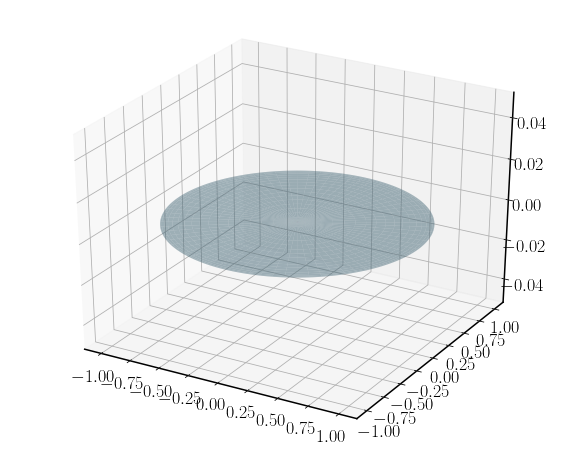

In [431]:
def get_cardinal_direction_coords(phi, theta):
    """Computes the cartesian x, y, z coordinates given the cardinal directions 
    system, where N=0, E=90, S=180, W=270 degrees. 
    
    Parameters:
    phi : float or array, polar angle in radians (note phi = 90-altitude)
    theta : float or array, azimuthal angle in radians
    
    Returns:
    x, y, z : tuple of floats or arrays, cartesian coordinates"""
    return np.sin(phi)*np.cos(theta), -np.sin(phi)*np.sin(theta), np.cos(phi)

def plot_sky_plane(r, phi, theta, ax):
    x, y, z = get_cardinal_direction_coords(phi, theta)
    x*=r
    y*=r
    z*=0
    ax.plot_surface(x, y, z, rstride=10, cstride=10, color='skyblue', alpha=0.5, linewidth=0)
    return


fig = plt.figure()
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
    
phi, theta = np.mgrid[0.0:0.5*np.pi:180j, 0.0:2.0*np.pi:720j] 
r = 1.0
plot_sky_plane(r, phi, theta, ax)
